# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, Reduction
import sscs
import matplotlib.pyplot as plt

2023-06-27 15:14:04.195819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-27 15:14:04.195893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-27 15:14:04.195909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-27 15:14:04.207049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 15:14:09,263	INFO worker.py:1636 -- Sta

## 2 - Download and extract dataset SSCS

In [2]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [3]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

2023-06-27 15:14:12.054804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 15:14:12.123783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 15:14:12.123855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 15:14:12.164163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 15:14:12.164239: I tensorflow/compile

In [4]:
voas_cnn = sscs.res_voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=2e-3),
                 loss=BinaryCrossentropy(reduction=Reduction.SUM_OVER_BATCH_SIZE))

#print(voas_cnn.summary())

sscs.load_weights(voas_cnn)
sscs.train(voas_cnn, ds_train, ds_val)  

## 4 - Evaluation with F-Score

In [5]:
songs = sscs.pick_songlist(amount=300, split='test')

def multivoice_f_score(song):
    mix, s, a, t, b = sscs.read_all_voice_splits(song)
    s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

    s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
    a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
    t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
    b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
    mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
    mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

    s_fscore = sscs.f_score(s, s_pred_postproc)
    a_fscore = sscs.f_score(a, a_pred_postproc)
    t_fscore = sscs.f_score(t, t_pred_postproc)
    b_fscore = sscs.f_score(b, b_pred_postproc)

    return [s_fscore, a_fscore, t_fscore, b_fscore]

#f_scores = np.array(list(map(multivoice_f_score, songs)))

In [6]:
f_scores = np.load('./Evaluation_Data/f-scores.npy')

In [7]:
s_counts, s_bins = np.histogram(f_scores[0], bins=100)
a_counts, a_bins = np.histogram(f_scores[1], bins=100)
t_counts, t_bins = np.histogram(f_scores[2], bins=100)
b_counts, b_bins = np.histogram(f_scores[3], bins=100)

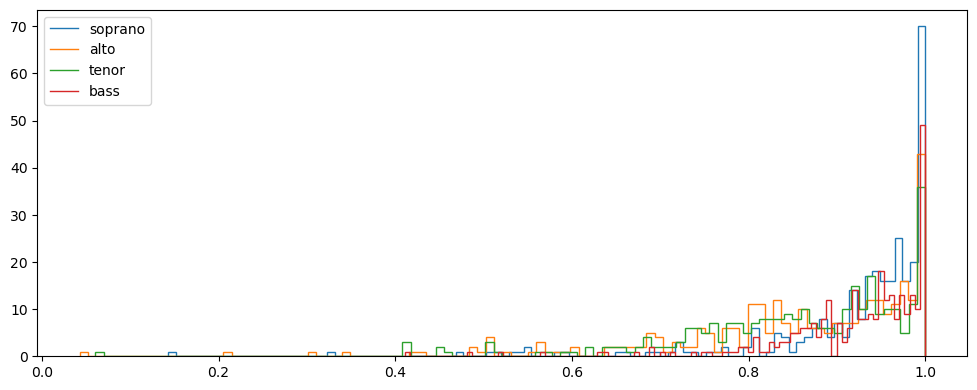

In [8]:
plt.figure(figsize=(12,4.5))
plt.stairs(s_counts, s_bins, label='soprano')
plt.stairs(a_counts, a_bins, label='alto')
plt.stairs(t_counts, t_bins, label='tenor')
plt.stairs(b_counts, b_bins, label='bass')
plt.legend()
plt.show()

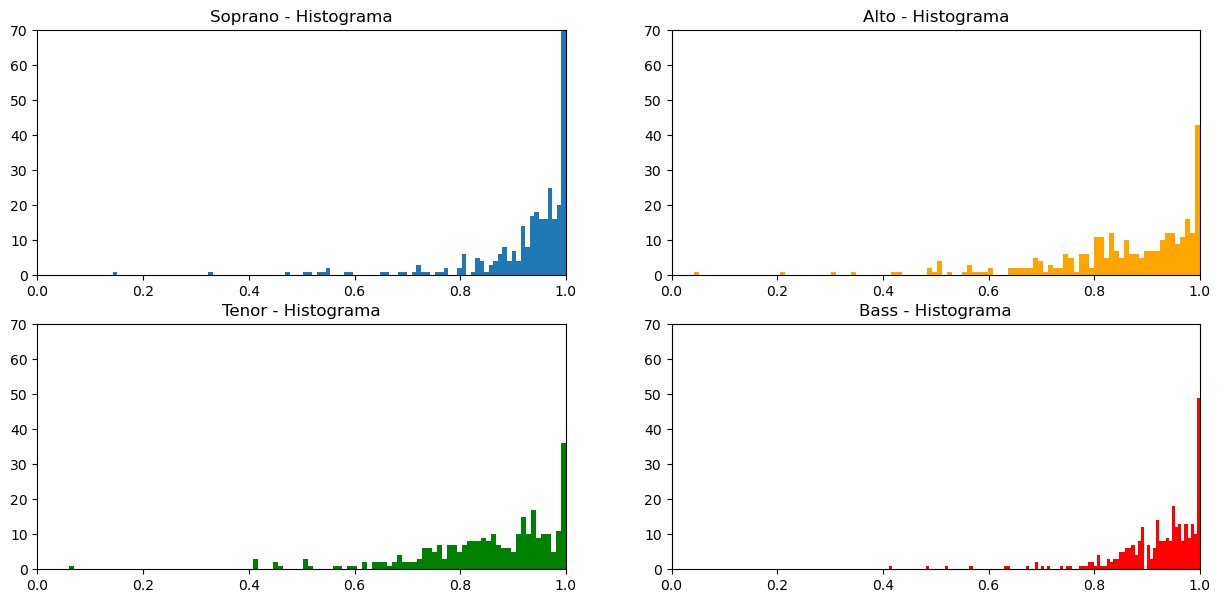

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs[0][0].stairs(s_counts, s_bins, fill=True)
axs[0][0].set_title("Soprano - Histograma")
axs[0][0].set_xlim([0, 1])
axs[0][0].set_ylim([0, 70])

axs[0][1].stairs(a_counts, a_bins, fill=True, color='orange')
axs[0][1].set_title("Alto - Histograma")
axs[0][1].set_xlim([0, 1])
axs[0][1].set_ylim([0, 70])

axs[1][0].stairs(t_counts, t_bins, fill=True, color='green')
axs[1][0].set_title("Tenor - Histograma")
axs[1][0].set_xlim([0, 1])
axs[1][0].set_ylim([0, 70])

axs[1][1].stairs(b_counts, b_bins, fill=True, color='red')
axs[1][1].set_title("Bass - Histograma")
axs[1][1].set_xlim([0, 1])
axs[1][1].set_ylim([0, 70])

plt.show()

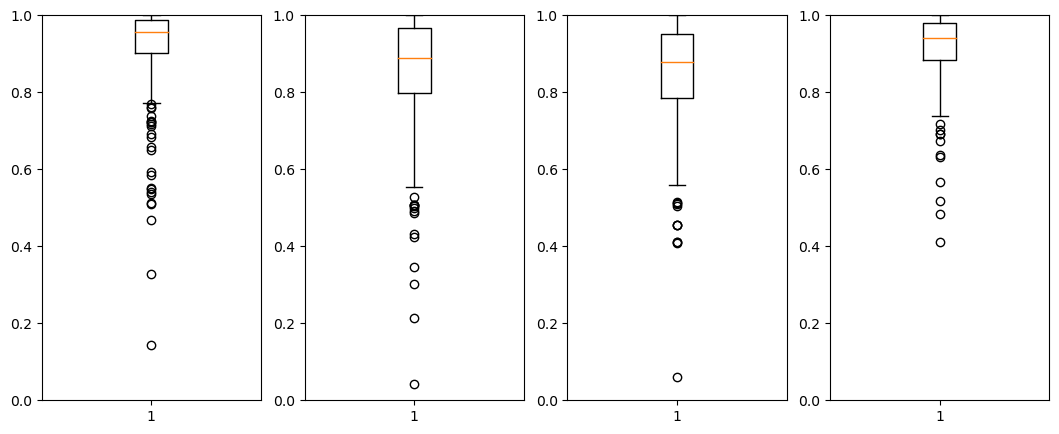

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(13, 5))
axs[0].boxplot(f_scores[0])
axs[1].boxplot(f_scores[1])
axs[2].boxplot(f_scores[2])
axs[3].boxplot(f_scores[3])

for ax in axs:
    ax.set_ylim([0, 1])

plt.show()

## 5 - Playground

(pid=3090) 2023-06-27 15:14:17.906108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3090) 2023-06-27 15:14:17.906160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3090) 2023-06-27 15:14:17.906172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3090) 2023-06-27 15:14:17.915499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=3090) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler fl

1/1 [==============================] - 6s 6s/step
F-Scores:
Soprano: 0.8763521134615413
Alto: 0.5769230269230812
Tenor: 0.6263521134615424
Bass: 0.9672475461538487



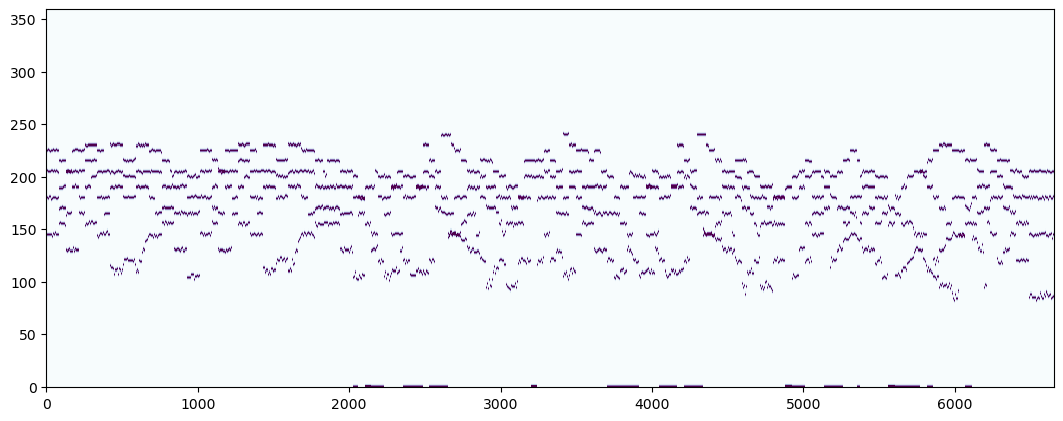

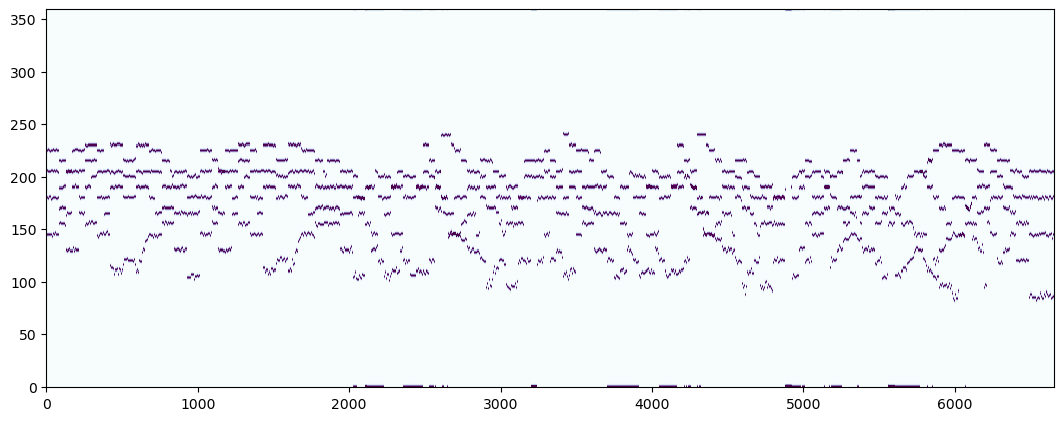

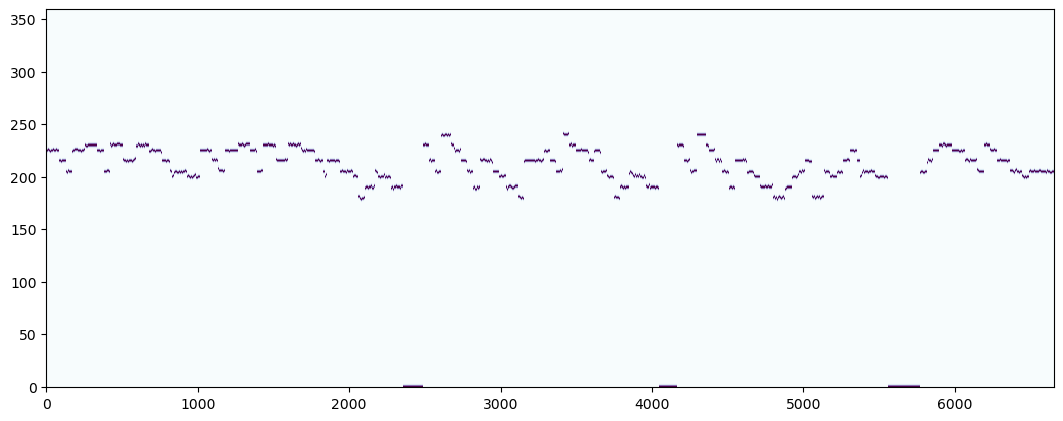

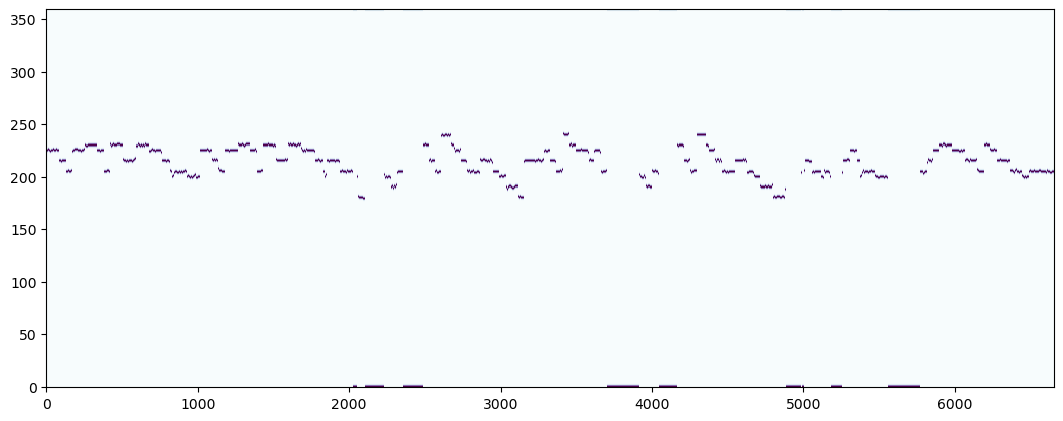

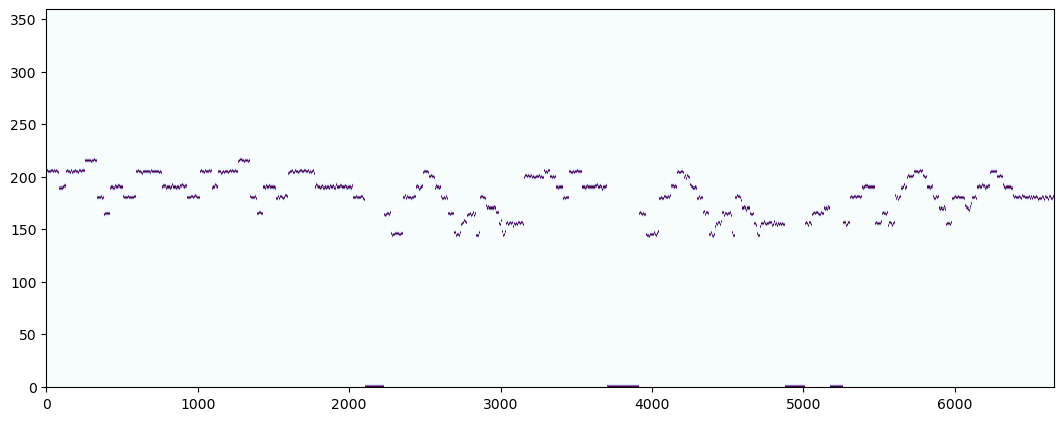

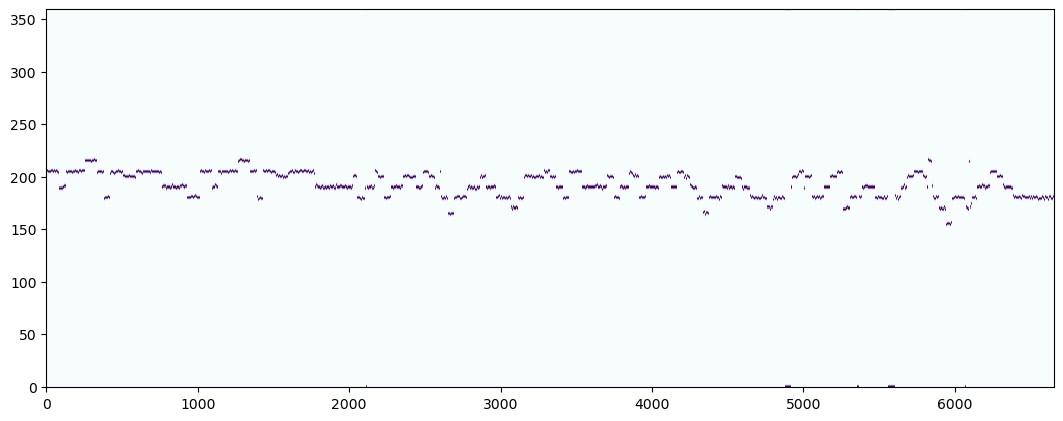

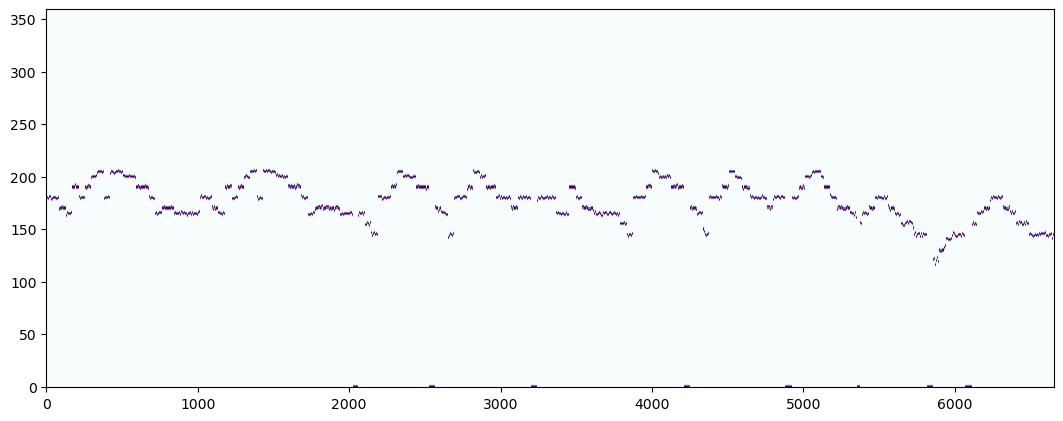

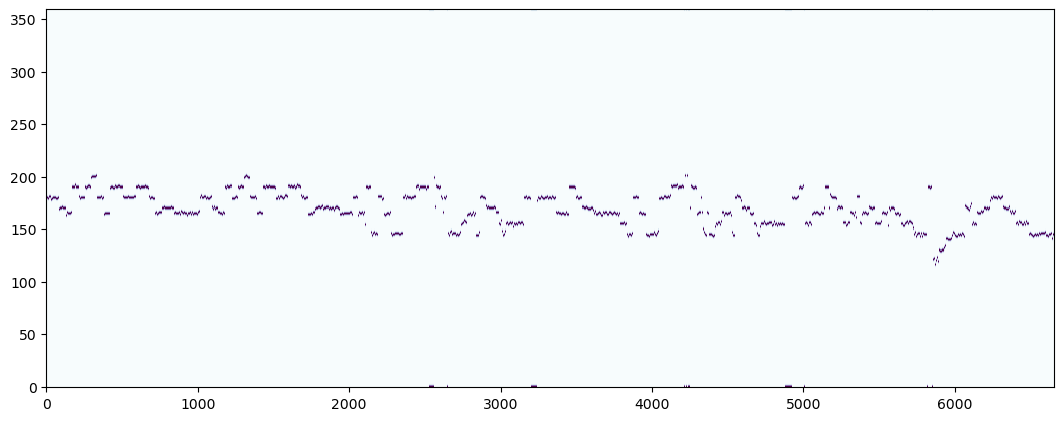

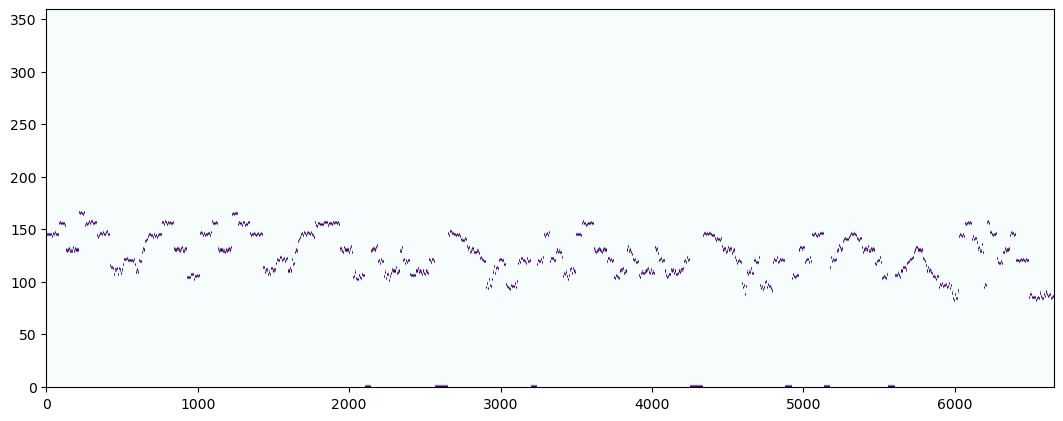

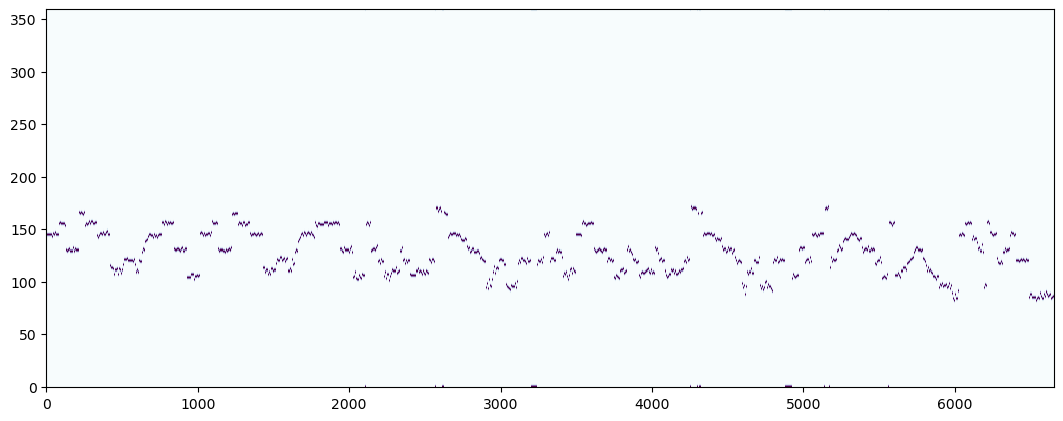

In [10]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

s_fscore = sscs.f_score(s, s_pred_postproc)
a_fscore = sscs.f_score(a, a_pred_postproc)
t_fscore = sscs.f_score(t, t_pred_postproc)
b_fscore = sscs.f_score(b, b_pred_postproc)

print("F-Scores:")
print(f"Soprano: {s_fscore}")
print(f"Alto: {a_fscore}")
print(f"Tenor: {t_fscore}")
print(f"Bass: {b_fscore}")
print()

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')